In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import tensorflow as tf
import os
from tqdm import tqdm
from tensorflow import keras

from src.utils import to_rgb
from src.satellite_images.storage import SentinelDataset, SentinelDatasetIterator
from src.mask.mask_dataset import MaskDataset, MaskDatasetIterator
from src.mask.utils import apply_mask_to_image_series, apply_mask_to_image

%load_ext autoreload
%autoreload 2

data_path = '../../../kornmo-data-files/raw-data/crop-classification-data/'

In [3]:
print("Reading data")
data = gpd.read_file(f"{data_path}/training_data.gpkg")
data['orgnr'] = data['orgnr'].astype(int)
data['year'] = data['year'].astype(int)

print("Reading masks")
masks = MaskDataset(f"{data_path}/small_masks_train.h5")

print("Reading satellite images")
satellite_imgs = SentinelDataset(f"{data_path}/small_images_train.h5")

print(f"Loaded {len(masks.labels)} masks")
print(f"Loaded {len(satellite_imgs.labels) * 30} images")

Reading data
Reading masks
Reading satellite images
Loaded 86079 masks
Loaded 2582370 images


In [4]:
data = data.loc[data['planted'] != 'erter']
# data = data.loc[data['planted'] != 'rughvete']
data = data.loc[data['planted'] != 'oljefro']
# data = data.loc[data['planted'] != 'rug']
data.drop(data[data['area'] < 1500].index, inplace = True)

labels = list(set(data['planted']))
n_classes = len(labels)
IMG_SIZE = 16
IMG_CHANNEL = 12

print(labels)
print(pd.Series(list(data['planted'])).value_counts())

['bygg', 'havre', 'hvete', 'rug', 'rughvete']
bygg        76231
havre       20512
hvete       18102
rug           816
rughvete      517
dtype: int64


In [5]:
def add_labels(orgnr, year, data_arg):
    orgnr = int(orgnr[:9])
    year = int(year)
    if orgnr in data['orgnr'].unique() and year in data.loc[data['orgnr'] == orgnr]['year'].unique():
        label = data.loc[data['orgnr'] == orgnr].loc[data['year'] == year]['planted'].iloc[0]
        index = labels.index(label)
        arr = [0 for _ in range(0, len(labels))]
        arr[index] = 1
        return {'class': arr}


In [6]:
train, val = satellite_imgs.to_iterator().split(rand_seed='corn')

train = train.with_data(add_labels, show_progress=True)
val = val.with_data(add_labels, show_progress=True)
masks_it = masks.get_iterator()
mask_dict = {}

for orgnr, year, mask in tqdm(masks_it, total=len(masks_it.labels)):
    mask_dict[f'{orgnr}/{year}'] = mask


print(f"train samples: {len(train)}")
print(f"val samples: {len(val)}")

#7737, 1937

100%|██████████| 86079/86079 [07:52<00:00, 182.01it/s]

train samples: 68569
val samples: 17153


In [7]:
import tensorflow_addons as tfa
from src.satellite_images.transform import salt_n_pepper

stride = 2
def top_left(imgs):
    return imgs[...,:-stride, :-stride,:]
def top_right(imgs):
    return imgs[...,:-stride, stride:,:]
def bot_left(imgs):
    return imgs[...,stride:, :-stride,:]
def bot_right(imgs):
    return imgs[...,stride:, stride:,:]
def center(imgs):
    s = stride//2
    return imgs[...,s:-s, s:-s,:]

def rotate_random(imgs):
    angle = tf.constant(np.pi/8)
    return tfa.image.rotate(imgs, angle)

def random_flip_left_right(imgs):
    return tf.image.random_flip_left_right(imgs)

def random_flip_up_down(imgs):
    return tf.image.random_flip_up_down(imgs)



augmented_dataset = train\
    .transform(salt_n_pepper())\
    .transform(rotate_random)\
    .transform(random_flip_left_right)\
    .transform(random_flip_up_down)\

#valnew = val.transform(center)

print(f"Augmented samples: {len(augmented_dataset)}")


Augmented samples: 68569


In [8]:

def train_generator():
    for orgnr, year, imgs, label in augmented_dataset:
        #imgs = apply_mask_to_image_series(mask_dict[f'{orgnr}/{year}'], imgs[4:20], image_size=IMG_SIZE)
        imgs = imgs[0:16]
        yield imgs, label['class']


def val_generator():
    for orgnr, year, imgs, label in val:
        #imgs = apply_mask_to_image_series(mask_dict[f'{orgnr}/{year}'], imgs[4:20], image_size=IMG_SIZE)
        imgs = imgs[0:30]
        yield imgs, label['class']



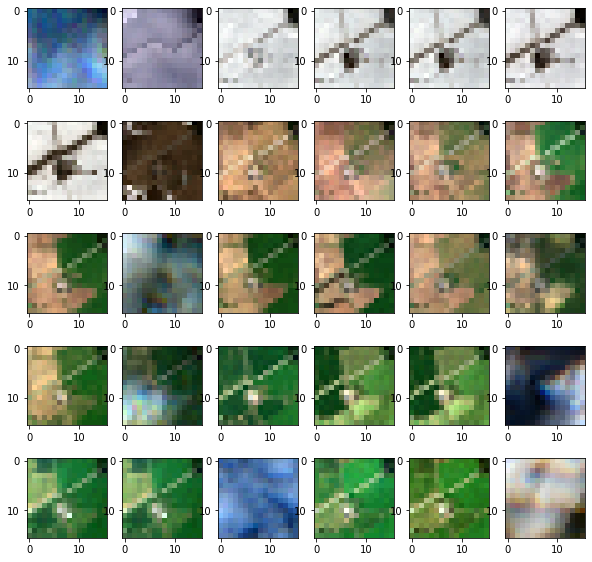

In [9]:
from src.utils import to_rgb
def plot_30_imgs(images):
    rows = 5
    cols = 6
    fig = plt.figure(figsize=(10,10))
    for i, img in enumerate(images):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(to_rgb(img))

i = 0
for imgs, _ in val_generator():
    if i == 0:
        plot_30_imgs(imgs)
        break
    i += 1

In [9]:

train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_types=(tf.dtypes.float64, tf.dtypes.int64),
    output_shapes=((16, IMG_SIZE, IMG_SIZE, IMG_CHANNEL), n_classes)
)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_types=(tf.dtypes.float64, tf.dtypes.int64),
    output_shapes=((16, IMG_SIZE, IMG_SIZE, IMG_CHANNEL), n_classes)
)



In [10]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D

def build_convnet(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNEL)):
    momentum = 0.9
    model = keras.Sequential()
    model.add(Conv2D(16, (3,3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    model.add(MaxPool2D())

    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))

    # model.add(MaxPool2D())
    #
    # model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    # model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    # model.add(BatchNormalization(momentum=momentum))

    # model.add(MaxPool2D())

    # model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    # model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    # model.add(BatchNormalization(momentum=momentum))

    # flatten...
    model.add(GlobalMaxPool2D())
    return model



In [11]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout, Reshape


def action_model(shape=(30, IMG_SIZE, IMG_SIZE, IMG_CHANNEL,), n_classes=n_classes):
    convnet = build_convnet(shape[1:])

    model = keras.Sequential()

    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(12))
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [ ]:

from keras.models import load_model
from src.kornmo.pyimagesearch.callbacks.epochcheckpoint import EpochCheckpoint
from src.kornmo.pyimagesearch.callbacks.trainingmonitor import TrainingMonitor

plotPath = os.path.sep.join(["training", "hybrid_more_features.png"])
jsonPath = os.path.sep.join(["training", "hybrid_more_features.json"])
callbacks = [EpochCheckpoint('./training', every=1, startAt=0),  TrainingMonitor(plotPath, jsonPath=jsonPath, startAt=0)]



restart = True
if restart:
    model = action_model(shape=(16, IMG_SIZE, IMG_SIZE, IMG_CHANNEL,))
    print(model.summary())
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    # optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.8, decay = 0.01)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])


    cnn_history = model.fit(
            train_dataset.take(10000).batch(32).prefetch(2),
            validation_data=val_dataset.batch(32).prefetch(2),
            epochs=100,
            verbose=1,
            #callbacks=callbacks,
    )
else:
    model = load_model('./training/epoch_2.hdf5')

    cnn_history = model.fit(
            train_dataset.take(10000).batch(32).prefetch(2),
            validation_data=val_dataset.batch(32).prefetch(2),
            epochs=100,
            verbose=1,
            #callbacks=callbacks,
    )



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 32)           18144     
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 12)                1656      
                                                                 
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                      

KeyboardInterrupt: 

In [13]:
#print(cnn_history)
N = np.arange(0, len(cnn_history.history["loss"]))
plt.figure()
plt.plot(N, cnn_history.history["loss"], label="train_loss")
plt.plot(N, cnn_history.history["val_loss"], label="val_loss")
plt.plot(N, cnn_history.history["acc"], label="train_acc")
plt.plot(N, cnn_history.history["val_acc"], label="val_acc")
plt.title(f"Training Loss and Accuracy [Epoch {len(cnn_history.history['loss'])}]")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('training/small_img_classification.png')

model.save('training/models/classification_1-16.hdf5', overwrite=True)
model.evaluate(x=val_dataset.batch(32).prefetch(2), verbose=1)

NameError: name 'cnn_history' is not defined

In [ ]:
from sklearn.metrics import classification_report

cnn_net = load_model('./training/epoch_16.hdf5')
res = cnn_net.predict(val_dataset, verbose=1)